In [1]:
import os
import re
import sys
import json
import logging
import collections
import pandas as pd
import numpy as np

from typing import Any, Literal, TypedDict, Callable, cast, TypeVar, Generic

In [ ]:
from html import unescape
import unicodedata

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hc
import scipy.spatial as sp

In [3]:
import time
from typing import Callable, Generic, TypeVar


KT = TypeVar('KT')
VT = TypeVar('VT')


MAX_RETRY = 10
RETRY_WAIT = 0.1


class LRU(Generic[KT, VT]):
    def __init__(
            self,
            max_items: int,
            soft_limit: int | None = None) -> None:
        self._values: dict[KT, VT] = {}
        self._times: dict[KT, float] = {}
        self._max_items = max_items
        self._soft_limit = (
            max(1, int(max_items * 0.9)) if soft_limit is None else soft_limit)
        assert self._max_items >= self._soft_limit

    def get(self, key: KT) -> VT | None:
        res = self._values.get(key)
        if res is not None:
            self._times[key] = time.monotonic()
        return res

    def set(self, key: KT, value: VT) -> None:
        self._values[key] = value
        self._times[key] = time.monotonic()
        self.gc()

    def clear_keys(self, prefix_match: Callable[[KT], bool]) -> None:
        for key in list(self._values.keys()):
            if prefix_match(key):
                self._values.pop(key, None)
                self._times.pop(key, None)

    def gc(self) -> None:
        retry = 0
        while len(self._values) > self._max_items:
            try:
                to_remove = sorted(
                    self._times.copy().items(),
                    key=lambda item: item[1])[:-self._soft_limit]
                for rm_item in to_remove:
                    key = rm_item[0]
                    self._values.pop(key, None)
                    self._times.pop(key, None)
            except RuntimeError:
                # dictionary changed size during iteration: try again
                if retry >= MAX_RETRY:
                    raise
                retry += 1
                if RETRY_WAIT > 0:
                    time.sleep(RETRY_WAIT)

In [4]:
import torch
from torch import nn

def get_device() -> torch.device:
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
device

device(type='mps')

In [5]:
from transformers import (
    DistilBertModel,
    DistilBertTokenizer,
    modeling_utils,
    get_scheduler,
)
from torch.optim import AdamW

In [6]:
from tqdm.auto import tqdm
import evaluate
import time

In [7]:
MODEL_FOLDER = "checkpoints"
os.makedirs(MODEL_FOLDER, exist_ok=True)

In [8]:
def batch_dot(batch_a: torch.Tensor, batch_b: torch.Tensor) -> torch.Tensor:
    batch_size = batch_a.shape[0]
    return torch.bmm(
        batch_a.reshape([batch_size, 1, -1]),
        batch_b.reshape([batch_size, -1, 1])).reshape([-1, 1])

In [9]:
TokenizedInput = TypedDict('TokenizedInput', {
    "text": list[str] | None,
    "input_ids": torch.Tensor,
    "attention_mask": torch.Tensor,
})

In [10]:
VERSION = 7
MODEL_BASE = {
    1: "distilbert-base-uncased",
    2: "distilbert-base-uncased",
    3: "distilbert-base-multilingual-cased",
    4: "distilbert-base-multilingual-cased",
    5: "distilbert-base-multilingual-cased",
    6: "distilbert-base-uncased",
    7: "distilbert-base-uncased",
}[VERSION]

In [11]:
def get_tokenizer() -> Callable[[list[str], bool], TokenizedInput]:
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_BASE)
    device = get_device()

    def tokens(texts: list[str], preserve_text: bool) -> TokenizedInput:
        res = tokenizer(
            texts, return_tensors="pt", padding=True, truncation=True)
        obj = {k: v.to(device) for k, v in res.items()}
        obj["text"] = texts if preserve_text else None
        return cast(TokenizedInput, obj)

    return tokens

In [12]:
AggType = Literal["cls", "mean"]
AGG_CLS: AggType = "cls"
AGG_MEAN: AggType = "mean"

In [13]:
class TagModel(nn.Module):
    def __init__(
            self,
            *,
            agg: AggType,
            base: str,
            ignore_pretrained_warning: bool = False) -> None:
        super().__init__()
        logger = modeling_utils.logger
        level = logger.getEffectiveLevel()
        try:
            if ignore_pretrained_warning:
                logger.setLevel(logging.ERROR)
            self._bert = DistilBertModel.from_pretrained(base)
        finally:
            if ignore_pretrained_warning:
                logger.setLevel(level)
        self._agg = agg
        self._test_lru = None
        
        def cache_hook(*args: Any, **kwargs: Any) -> None:
            self.clear_cache()
        
        self.register_load_state_dict_post_hook(cache_hook)
        self.register_state_dict_pre_hook(cache_hook)

    def _get_agg(self, lhs: torch.Tensor) -> torch.Tensor:
        if self._agg == AGG_CLS:
            return lhs[:, 0]
        if self._agg == AGG_MEAN:
            return torch.mean(lhs, dim=1)
        raise ValueError(f"unknown aggregation: {self._agg}")

    def _embed(
            self,
            input_ids: torch.Tensor,
            attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self._bert(
            input_ids=input_ids, attention_mask=attention_mask)
        out = self._get_agg(outputs.last_hidden_state)
        return out
    
    def clear_cache(self) -> None:
        self._test_lru = None

    def forward(
            self,
            x: TokenizedInput) -> torch.Tensor:
        if self.training and self._test_lru is not None:
            self.clear_cache()
        if not self.training:
            if self._test_lru is None:
                self._test_lru = LRU(1000)
            if x["text"] is not None:
                res = []
                for row_ix, text in enumerate(x["text"]):
                    cache_res = self._test_lru.get(text)
                    if cache_res is None:
                        cache_res = self._embed(
                            input_ids=x["input_ids"][[row_ix]],
                            attention_mask=x["attention_mask"][[row_ix]]).detach()
                        self._test_lru.set(text, cache_res)
                    res.append(torch.clone(cache_res))
                return torch.vstack(res)
        return self._embed(
            input_ids=x["input_ids"],
            attention_mask=x["attention_mask"])


class TrainingHarness(nn.Module):
    def __init__(self, model: TagModel, model_right: TagModel | None, use_cos: bool) -> None:
        super().__init__()
        self._model_left = model
        self._model_right = model if model_right is None else model_right
        self._loss = nn.BCELoss()
        self._cos = nn.CosineSimilarity() if use_cos else None
        
    def _combine(self, left_embed: torch.Tensor, right_embed: torch.Tensor) -> torch.Tensor:
        if self._cos is None:
            # NOTE: torch.sigmoid would be a bad idea here
            return batch_dot(left_embed, right_embed)
        return self._cos(left_embed, right_embed).reshape([-1, 1])
    
    def get_model_left(self) -> TagModel:
        return self._model_left
    
    def get_model_right(self) -> TagModel:
        return self._model_right

    def forward(
            self,
            *,
            left: TokenizedInput,
            right: TokenizedInput,
            labels: torch.Tensor | None = None,
            force_left_model: bool | None = None) -> tuple[torch.Tensor, torch.Tensor] | torch.Tensor:
        left_embed = self._model_right(left) if force_left_model is False else self._model_left(left)
        right_embed = self._model_left(right) if force_left_model is True else self._model_right(right)
        preds = self._combine(left_embed, right_embed)
        if labels is None:
            return preds
        probs = torch.hstack([1.0 - preds, preds])
        return preds, self._loss(probs, labels)

In [14]:
tokens = get_tokenizer()

In [15]:
def create_model(config) -> TagModel:
    return TagModel(agg=config["agg"], base=config["base"], ignore_pretrained_warning=True)


def load_model(harness, model_fname):
    print(f"loading {model_fname}")
    with open(model_fname, "rb") as fin:
        harness.load_state_dict(torch.load(fin, map_location=device))


def compute(harness, df, *, preserve_text):
    lefts = tokens(df["left"].tolist(), preserve_text)
    rights = tokens(df["right"].tolist(), preserve_text)
    labels = torch.tensor(
        np.array([~df["is_correct"], df["is_correct"]]),
        dtype=torch.float32).T.to(device)
   
    preds, loss = harness(
        left=lefts,
        right=rights,
        labels=labels)
    return preds, loss


def run_training(*, prefix, num_epochs, train_size, train_df_gen, test_df, config, resume, skip_test):
    model_left = create_model(config)
    model_left.to(device)
    if config["one_embedding"]:
        model_right = None
    else:
        model_right = create_model(config)
        model_right.to(device)
    harness = TrainingHarness(model_left, model_right, use_cos=config["use_cos"])
    harness.to(device)

    try:
        batch_size_train = 3
        batch_size_test = 12
        est_th = 0.5
        optimizer = AdamW(harness.parameters(), lr=5e-5)

        num_training_steps = num_epochs * train_size // batch_size_train
        warmup = 1000
        lr_scheduler = get_scheduler(
            name="linear",
            optimizer=optimizer,
            num_warmup_steps=warmup,
            num_training_steps=num_training_steps - warmup)

        for epoch in range(num_epochs):
            print(f"epoch {epoch} train size {train_size} test size {test_df.shape[0]}")
            real_time = time.monotonic()

            model_fname = os.path.join(MODEL_FOLDER, f"{prefix}_model_{epoch}.pkl")
            stats_fname = os.path.join(MODEL_FOLDER, f"{prefix}_stats_{epoch}.json")

            acc_train = evaluate.load("accuracy")
            pre_train = evaluate.load("precision")
            rec_train = evaluate.load("recall")
            train_loss = []

            cur_skip_test = skip_test
            if os.path.exists(model_fname) or os.path.exists(stats_fname):
                if os.path.exists(model_fname):
                    load_model(harness, model_fname)
                else:
                    print("WARNING: stats file detected but no model file. not loading model", file=sys.stderr)
                train_loss.append(0)
                acc_train.add_batch(
                    predictions=[0, 1],
                    references=[0, 1])
                pre_train.add_batch(
                    predictions=[0, 1],
                    references=[0, 1])
                rec_train.add_batch(
                    predictions=[0, 1],
                    references=[0, 1])
            else:
                train_df = train_df_gen(config, train_size)
                model_left = harness.get_model_left()
                model_left.train()
                model_right = harness.get_model_right()
                model_right.train()
                harness.train()
                with tqdm(desc="train", total=train_df.shape[0]) as progress_bar:
                    for train_chunk in np.array_split(train_df, np.ceil(train_df.shape[0] / batch_size_train)):
                        preds, loss = compute(harness, train_chunk, preserve_text=False)
                        train_loss.append(loss.item())
                        loss.backward()

                        optimizer.step()
                        lr_scheduler.step()
                        optimizer.zero_grad()
                        progress_bar.update(train_chunk.shape[0])

                        labels = train_chunk["is_correct"].astype(int).to_numpy()
                        predictions = (preds > est_th).to(int)
                        acc_train.add_batch(
                            predictions=predictions,
                            references=labels)
                        pre_train.add_batch(
                            predictions=predictions,
                            references=labels)
                        rec_train.add_batch(
                            predictions=predictions,
                            references=labels)

                torch.save(harness.state_dict(), model_fname)
                cur_skip_test = False

            if not cur_skip_test:
                acc_test = evaluate.load("accuracy")
                pre_test = evaluate.load("precision")
                rec_test = evaluate.load("recall")
                test_loss = []

                model_left = harness.get_model_left()
                model_left.eval()
                model_right = harness.get_model_right()
                model_right.eval()
                harness.eval()
                with torch.no_grad():
                    with tqdm(desc="test", total=test_df.shape[0]) as progress_bar:
                        for test_chunk in np.array_split(test_df, np.ceil(test_df.shape[0] / batch_size_test)):
                            preds, loss = compute(harness, test_chunk, preserve_text=True)
                            test_loss.append(loss.item())

                            progress_bar.update(test_chunk.shape[0])
                            
                            labels = test_chunk["is_correct"].astype(int).to_numpy()
                            predictions = (preds > est_th).to(int)
                            acc_test.add_batch(
                                predictions=predictions,
                                references=labels)
                            pre_test.add_batch(
                                predictions=predictions,
                                references=labels)
                            rec_test.add_batch(
                                predictions=predictions,
                                references=labels)

                stats = {
                    "epoch": int(epoch),
                    "train_acc": float(acc_train.compute()["accuracy"]),
                    "train_pre": float(pre_train.compute()["precision"]),
                    "train_rec": float(rec_train.compute()["recall"]),
                    "train_loss": float(np.mean(train_loss)),
                    "test_acc": float(acc_test.compute()["accuracy"]),
                    "test_pre": float(pre_test.compute()["precision"]),
                    "test_rec": float(rec_test.compute()["recall"]),
                    "test_loss": float(np.mean(test_loss)),
                    "time": 0.0,
                    "config": config,
                    "version": VERSION,
                }

                print(
                    f"train[acc: {stats['train_acc']} "
                    f"pre: {stats['train_pre']} "
                    f"rec: {stats['train_rec']} "
                    f"loss: {stats['train_loss']}]")
                print(
                    f"test[acc: {stats['test_acc']} "
                    f"pre: {stats['test_pre']} "
                    f"rec: {stats['test_rec']} "
                    f"loss: {stats['test_loss']}]")
                stats["time"] = float((time.monotonic() - real_time) / 60.0)
                print(f"epoch time: {stats['time']:.2f}min")

                with open(stats_fname, "w") as fout:
                    print(json.dumps(stats, indent=4, sort_keys=True), file=fout)
    
    except KeyboardInterrupt:
        print("TERMINATED BY USER", file=sys.stderr)
    return harness

In [16]:
DF = pd.read_parquet("traintest.pq")
DF = DF[DF["lang"] == "en"]
DF

,stage,id,db,country,lang,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
0,validation,5019,sm,GIN,en,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,validation,5164,sm,GIN,en,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,test,5022,sm,GIN,en,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,train,2783,sm,GIN,en,Public Lights auto managed,Public Lights auto managed \nSolution developp...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,test,5021,sm,GIN,en,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,validation,197,exp,LBY,en,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4011,validation,362,exp,GTM,en,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4012,validation,252,exp,PHL,en,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...",False,False,False,...,False,False,False,False,False,False,False,False,False,False
4013,validation,241,exp,PHL,en,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
FULL_TRAIN = DF[DF["stage"] == "train"]
FULL_TEST = DF[DF["stage"] == "test"]
FULL_REST = DF[(DF["stage"] != "train") & (DF["stage"] != "test")]
display(FULL_TRAIN)
display(FULL_TEST)
FULL_TRAIN.shape, FULL_TEST.shape, FULL_REST.shape

,stage,id,db,country,lang,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
3,train,2783,sm,GIN,en,Public Lights auto managed,Public Lights auto managed \nSolution developp...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,train,4466,sm,MKD,en,"Certificates (birth, marriage): request and de...","Certificates (birth, marriage): request and de...",False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,train,5367,sm,SWZ,en,Ndinda Gully Rehabilitation Project,Ndinda Gully Rehabilitation Project \nSmallhol...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,train,4357,sm,ETH,en,Improved cook stove,Improved cook stove\nSileshi Abebe Alemayehu ...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15,train,1171,sm,IRQ,en,"Simawa Rugs, A Biomimicry Social Textile Proje...","Simawa Rugs, A Biomimicry Social Textile Proje...",False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,train,1822,sm,KHM,en,Natural Biogas Plants,Natural Biogas Plants\n\n\nThis natural biogas...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2938,train,5954,sm,SYR,en,A Syria geography teacher innovates a new mach...,A Syria geography teacher innovates a new mach...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2941,train,5782,sm,ARG,en,Citizen science on monitoring and mapping of t...,Citizen science on monitoring and mapping of t...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2943,train,5965,sm,ARG,en,Citizen Science on monitoring of invasive alie...,Citizen Science on monitoring of invasive alie...,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,stage,id,db,country,lang,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
2,test,5022,sm,GIN,en,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,test,5021,sm,GIN,en,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8,test,4364,sm,ETH,en,Tikikil stove,Tikikil stove\nGIZ\nOffice contact GIZ Office ...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,test,5777,sm,ETH,en,Green Tech Packaging Solutions,Green Tech Packaging Solutions \nDesign and de...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18,test,5827,sm,IRQ,en,Origins: Personal Incubator,Origins: Personal Incubator\nWhat is Origins?\...,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,test,5935,sm,GTM,en,Solar Tuk Tuk,Solar Tuk Tuk\n\n\nThis is the Tuk Tuk Solar 2...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2919,test,5937,sm,GTM,en,Electric Scooters,Electric Scooters\n\n\nThe new scooters in Gua...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2927,test,5943,sm,GTM,en,InProtein,InProtein\n\n\nThey propose more efficient and...,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2932,test,4690,sm,BGD,en,Safepad - sustainable sanitary napkin,Safepad - sustainable sanitary napkin\n\n\nSaf...,False,False,False,...,False,False,False,False,False,False,False,False,False,False


((764, 881), (767, 881), (1936, 881))

In [18]:
RNG = np.random.default_rng(42)

In [19]:
TAG_PREFIX = "tag_"
TAG_COLS = [col for col in DF.columns if col.startswith(TAG_PREFIX)]
TAGS = [col[len(TAG_PREFIX):] for col in TAG_COLS]

def get_tags(df: pd.DataFrame, ix: int) -> list[str]:
    cur = df.iloc[ix][TAG_COLS]
    return sorted(col[len(TAG_PREFIX):] for col in cur[cur].index)

TAGS[:10]

['3d printing',
 'Acupuntura Urbana',
 'Bebidas Tradicionales',
 'Bicicleta',
 'Bicycle',
 'Cadenas de Valor',
 'Coca',
 'Conectividad',
 'Construction',
 'Contactlessness']

In [20]:
def clean(text: str) -> str:
    text = text.strip()
    while True:
        prev_text = text
        text = unescape(text)
        if prev_text == text:
            break
    text = unicodedata.normalize("NFKC", text)
    return re.sub("\n\n\n+", "\n\n", re.sub("[ \t]+", " ", re.sub("\n[ \t]+", "\n", re.sub("\n\n+", "\n", re.sub("\r", "\n", text)))))


def build_df(full_df: pd.DataFrame, num_rows: int | None, *, prob_correct: float = 0.5) -> pd.DataFrame:
    df_builder = {
        "left": [],
        "right": [],
        "is_correct": [],
    }
    if num_rows is None:
        ixs = list(range(full_df.shape[0]))
    else:
        ixs = RNG.choice(list(range(full_df.shape[0])), num_rows, replace=True)
    for row_ix in ixs:
        cur_row = full_df.iloc[row_ix]
        cur_text = clean(f"{cur_row['title']}:\n{cur_row['text']}")
        cur_tags = get_tags(full_df, row_ix)
        if num_rows is None:
            for tag in TAGS:
                df_builder["right"].append(cur_text)
                df_builder["left"].append(tag)
                df_builder["is_correct"].append(bool(cur_row[f"{TAG_PREFIX}{tag}"]))
        else:
            df_builder["right"].append(cur_text)
            if cur_tags and RNG.random() < prob_correct:
                df_builder["left"].append(RNG.choice(cur_tags, 1)[0])
                df_builder["is_correct"].append(True)
            else:
                tag = RNG.choice(TAGS, 1)[0]
                df_builder["left"].append(tag)
                df_builder["is_correct"].append(bool(cur_row[f"{TAG_PREFIX}{tag}"]))
    return pd.DataFrame(df_builder, columns=["left", "right", "is_correct"])

In [21]:
TEST_DF = build_df(FULL_TEST, None).groupby("is_correct", group_keys=False).apply(lambda x: x.sample(min(x.shape[0], 5000)))
TEST_DF = TEST_DF.sort_values("right")
TEST_DF

,left,right,is_correct
445357,lack of open data,"""Ai Nono"" - Traditional practice of construct...",False
445135,digital services,"""Ai Nono"" - Traditional practice of construct...",False
445662,transfer of knowledge and technology,"""Ai Nono"" - Traditional practice of construct...",True
444902,Peace & Equality (Justice),"""Ai Nono"" - Traditional practice of construct...",False
445217,evaluation,"""Ai Nono"" - Traditional practice of construct...",False
...,...,...,...
608255,wash,“Books on the Road”:\n“Books on the Road”\nMee...,False
607457,Library,“Books on the Road”:\n“Books on the Road”\nMee...,True
607716,disaster risk reduction,“Books on the Road”:\n“Books on the Road”\nMee...,False
608035,pop-up,“Books on the Road”:\n“Books on the Road”\nMee...,True


In [22]:
harness = run_training(
    prefix=f"v{VERSION}",
    num_epochs=6,
    train_size=12000,
    train_df_gen=lambda config, size: build_df(FULL_TRAIN, size, prob_correct=config["proc_correct"]),
    test_df=TEST_DF,
    config={
        "agg": "cls",
        "use_cos": True,
        "proc_correct": 0.6,
        "base": MODEL_BASE,
        "one_embedding": False,
    },
    resume=True,
    skip_test=True)

epoch 0 train size 12000 test size 7332


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/7332 [00:00<?, ?it/s]

train[acc: 0.59275 pre: 0.6144602851323829 rec: 0.8456902592852137 loss: 0.7307352780103683]
test[acc: 0.4247135842880524 pre: 0.3508855154965212 rec: 0.9515437392795884 loss: 0.7551082273161743]
epoch time: 38.85min
epoch 1 train size 12000 test size 7332


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/7332 [00:00<?, ?it/s]

train[acc: 0.6608333333333334 pre: 0.6452035563874591 rec: 0.9611041405269761 loss: 0.6194495059400796]
test[acc: 0.5222313147845062 pre: 0.39163427725337774 rec: 0.9073756432246999 loss: 0.6964359361489354]
epoch time: 36.05min
epoch 2 train size 12000 test size 7332


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/7332 [00:00<?, ?it/s]

train[acc: 0.69925 pre: 0.6799273021001615 rec: 0.9387982712951345 loss: 0.5846011509336532]
test[acc: 0.5946535733769777 pre: 0.4322033898305085 rec: 0.8747855917667239 loss: 0.6493588332361169]
epoch time: 36.70min
epoch 3 train size 12000 test size 7332


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/7332 [00:00<?, ?it/s]

train[acc: 0.6119166666666667 pre: 0.6104081119584346 rec: 0.9989029072956664 loss: 0.6709066894352436]
test[acc: 0.3180578286961266 pre: 0.3180578286961266 rec: 1.0 loss: 0.9010492059876213]
epoch time: 36.25min
epoch 4 train size 12000 test size 7332


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/7332 [00:00<?, ?it/s]

train[acc: 0.6013333333333334 pre: 0.6013333333333334 rec: 1.0 loss: 0.6762888046130539]
test[acc: 0.3180578286961266 pre: 0.3180578286961266 rec: 1.0 loss: 0.8933856357529198]
epoch time: 36.92min
epoch 5 train size 12000 test size 7332


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/7332 [00:00<?, ?it/s]

train[acc: 0.6013333333333334 pre: 0.6013333333333334 rec: 1.0 loss: 0.6753538555279374]
test[acc: 0.3180578286961266 pre: 0.3180578286961266 rec: 1.0 loss: 0.8914935013276271]
epoch time: 37.99min


In [23]:
def compute_tag_matrix(harness: TrainingHarness) -> pd.DataFrame:
    plan = []
    for lix, left in enumerate(TAGS):
        for rix, right in enumerate(TAGS):
            if lix > rix:
                continue
            plan.append((lix, rix, left, right))
    
    res = np.zeros((len(TAGS), len(TAGS)))
    batch_size = 16
    model = harness.get_model_left()
    model.eval()
    with torch.no_grad():
        with tqdm(desc="tags", total=len(plan)) as progress_bar:
            for chunk in np.array_split(plan, np.ceil(len(plan) / batch_size)):
                lixs, rixs, left_strs, right_strs = tuple(zip(*chunk))
                lefts = tokens(left_strs, True)
                rights = tokens(right_strs, True)   
                preds = harness(
                    left=lefts,
                    right=rights,
                    force_left_model=True)
                for lix, rix, val in zip(lixs, rixs, preds.ravel().tolist()):
                    res[int(lix), int(rix)] = val
                    res[int(rix), int(lix)] = val
                progress_bar.update(chunk.shape[0])
    return pd.DataFrame(res, columns=TAGS, index=TAGS)

In [24]:
TAG_FILE = f"tags_{VERSION}.pq"
if os.path.exists(TAG_FILE):
    tag_matrix = pd.read_parquet(TAG_FILE)
else:
    tag_matrix = compute_tag_matrix(harness)
    tag_matrix.to_parquet(TAG_FILE)
tag_matrix

tags:   0%|          | 0/382375 [00:00<?, ?it/s]

,3d printing,Acupuntura Urbana,Bebidas Tradicionales,Bicicleta,Bicycle,Cadenas de Valor,Coca,Conectividad,Construction,Contactlessness,...,wood gas,wood stove,woodchips,worker safety,youth,youth activism,youth and unemployment,youth empowerment,youth informality,zero waste
3d printing,1.000000,0.988440,0.978707,0.985412,0.989276,0.985946,0.986117,0.993374,0.973918,0.994181,...,0.995195,0.992308,0.995621,0.987637,0.993260,0.989893,0.994724,0.995257,0.995081,0.995115
Acupuntura Urbana,0.988440,1.000000,0.995187,0.996386,0.978692,0.996798,0.975537,0.991346,0.966105,0.982660,...,0.992665,0.993412,0.993835,0.975157,0.982264,0.977668,0.986588,0.986327,0.987870,0.982740
Bebidas Tradicionales,0.978707,0.995187,1.000000,0.993802,0.967588,0.995941,0.963777,0.983126,0.955359,0.972477,...,0.986259,0.988336,0.987246,0.964569,0.971551,0.966103,0.978585,0.977319,0.979842,0.972247
Bicicleta,0.985412,0.996386,0.993802,1.000000,0.979525,0.996092,0.976706,0.989965,0.967461,0.981268,...,0.993364,0.994020,0.992952,0.974592,0.981689,0.977160,0.985490,0.985076,0.986530,0.982041
Bicycle,0.989276,0.978692,0.967588,0.979525,1.000000,0.977714,0.998790,0.993282,0.992615,0.995874,...,0.987506,0.982138,0.987679,0.993592,0.997198,0.997328,0.987908,0.990564,0.987256,0.996623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youth activism,0.989893,0.977668,0.966103,0.977160,0.997328,0.976736,0.996964,0.993673,0.986674,0.997764,...,0.987646,0.981461,0.988184,0.997161,0.998151,1.000000,0.990965,0.993700,0.990261,0.997627
youth and unemployment,0.994724,0.986588,0.978585,0.985490,0.987908,0.986046,0.984625,0.991557,0.971827,0.994742,...,0.995563,0.993170,0.993928,0.988948,0.994687,0.990965,1.000000,0.999212,0.999268,0.994486
youth empowerment,0.995257,0.986327,0.977319,0.985076,0.990564,0.985561,0.988112,0.992707,0.975379,0.996557,...,0.995464,0.992214,0.994095,0.991506,0.996652,0.993700,0.999212,1.000000,0.999014,0.996209
youth informality,0.995081,0.987870,0.979842,0.986530,0.987256,0.986721,0.984195,0.991763,0.970818,0.994459,...,0.996196,0.994117,0.995015,0.988333,0.993846,0.990261,0.999268,0.999014,1.000000,0.993894


In [25]:
(1.0 - tag_matrix.to_numpy()).round(6)

array([[-0.      ,  0.01156 ,  0.021293, ...,  0.004743,  0.004919,
         0.004885],
       [ 0.01156 ,  0.      ,  0.004813, ...,  0.013673,  0.01213 ,
         0.01726 ],
       [ 0.021293,  0.004813,  0.      , ...,  0.022681,  0.020158,
         0.027753],
       ...,
       [ 0.004743,  0.013673,  0.022681, ...,  0.      ,  0.000986,
         0.003791],
       [ 0.004919,  0.01213 ,  0.020158, ...,  0.000986, -0.      ,
         0.006106],
       [ 0.004885,  0.01726 ,  0.027753, ...,  0.003791,  0.006106,
         0.      ]])

In [26]:
tag_linkage = hc.linkage(sp.distance.squareform((1.0 - tag_matrix.to_numpy()).round(6)), method="average")

In [27]:
sns.clustermap(
    tag_matrix,
    row_linkage=tag_linkage,
    col_linkage=tag_linkage,
    cmap="OrRd",
    figsize=(300, 300),
    linewidth=0)
plt.savefig(f"dendrogram_large_{VERSION}.png", bbox_inches="tight")
plt.close()

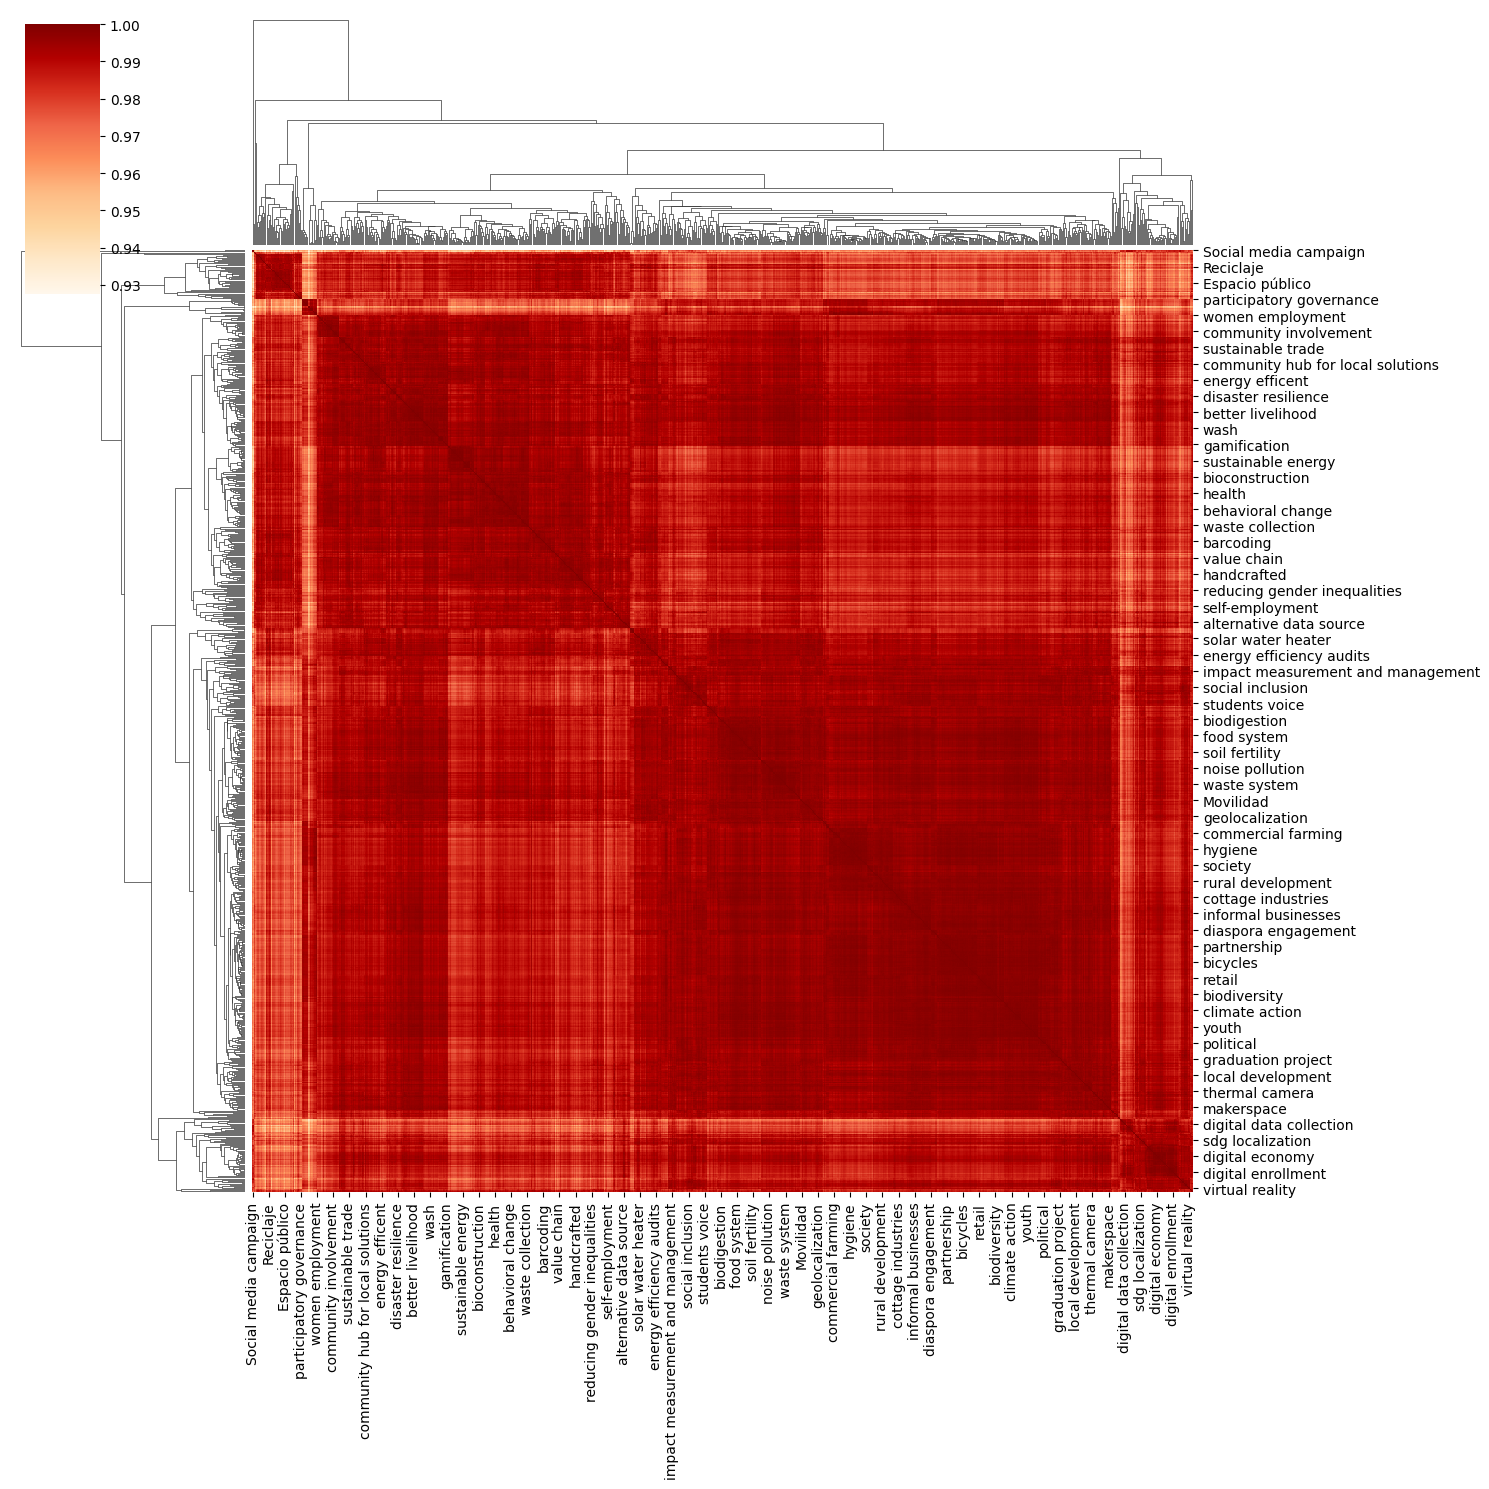

In [28]:
sns.clustermap(
    tag_matrix,
    row_linkage=tag_linkage,
    col_linkage=tag_linkage,
    cmap="OrRd",
    figsize=(15, 15),
    linewidth=0)
plt.savefig(f"dendrogram_{VERSION}.png", bbox_inches="tight")

In [29]:
len(TAGS)

874

In [30]:
def get_preds(df: pd.DataFrame, harness: TrainingHarness) -> pd.DataFrame:
    batch_size = 16
    model_left = harness.get_model_left()
    model_left.eval()
    model_right = harness.get_model_right()
    model_right.eval()
    harness.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        with tqdm(desc="data", total=df.shape[0]) as progress_bar:
            for chunk in np.array_split(df, np.ceil(df.shape[0] / batch_size)):
                preds, _ = compute(harness, chunk, preserve_text=True)

                progress_bar.update(chunk.shape[0])
                all_preds.extend(preds.ravel().tolist())
                all_labels.extend(chunk["is_correct"].astype(int).to_list())
    return pd.DataFrame({"preds": all_preds, "labels": all_labels}, columns=["preds", "labels"])

In [31]:
preds = get_preds(TEST_DF, harness)
preds

data:   0%|          | 0/7332 [00:00<?, ?it/s]

,preds,labels
0,0.661269,0
1,0.676607,0
2,0.673674,1
3,0.667862,0
4,0.670301,0
...,...,...
7327,0.689508,0
7328,0.687014,1
7329,0.681354,0
7330,0.678820,1


In [32]:
preds["labels"].astype(bool).describe()

count      7332
unique        2
top       False
freq       5000
Name: labels, dtype: object

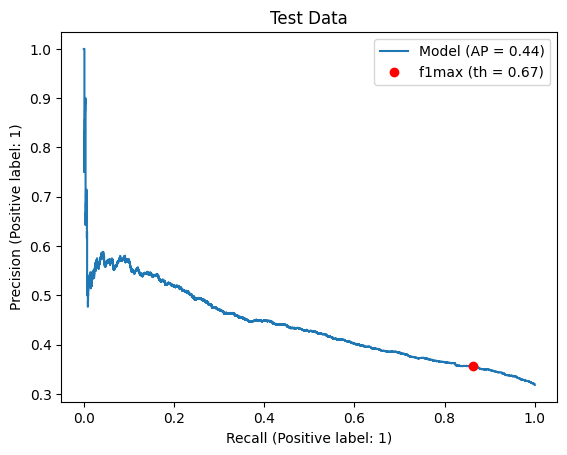

In [33]:
precision, recall, thresholds = precision_recall_curve(preds["labels"], preds["preds"], pos_label=1)
f1_scores = 2 * recall * precision / (recall + precision)
best_th_ix = np.nanargmax(f1_scores)
best_thresh = thresholds[best_th_ix]
average_precision = average_precision_score(preds["labels"], preds["preds"], pos_label=1)
display = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=average_precision,
    estimator_name="Model",
    pos_label=1)
display.plot(name="Model")
display.ax_.set_title("Test Data")
display.ax_.plot(recall[best_th_ix], precision[best_th_ix], "ro", label=f"f1max (th = {best_thresh:.2f})")
display.ax_.legend()
None

In [34]:
def add_embeds(
        df: pd.DataFrame,
        harness: TrainingHarness,
        name: str,
        embeds: list[np.ndarray],
        names: list[str],
        *,
        is_right: bool) -> None:
    batch_size = 8
    model = harness.get_model_right() if is_right else harness.get_model_left()
    model.eval()
    with torch.no_grad():
        with tqdm(desc=name, total=df.shape[0]) as progress_bar:
            for chunk in np.array_split(df, np.ceil(df.shape[0] / batch_size)):
                embed = model(tokens([clean(txt) for txt in chunk["text"].tolist()], False))
                embeds.append(embed.numpy(force=True))
                names.extend([f"{'r' if is_right else 'l'}_{name}"] * chunk.shape[0])
                
                progress_bar.update(chunk.shape[0])

In [35]:
def get_all_embeds(harness: TrainingHarness) -> tuple[np.ndarray, list[str]]:
    embeds = []
    names = []
    add_embeds(pd.DataFrame({"text": FULL_REST["title"].astype(str)}), harness, "title", embeds, names, is_right=False)
    add_embeds(
        pd.DataFrame({"text": FULL_REST["title"].astype(str) + ":\n" + FULL_REST["text"].astype(str)}),
        harness,
        "full",
        embeds,
        names,
        is_right=True)
    add_embeds(pd.DataFrame({"text": TAGS}), harness, "tags", embeds, names, is_right=False)
    return np.vstack(embeds), names

In [36]:
ALL_EMBEDS, ALL_NAMES = get_all_embeds(harness)
ALL_EMBEDS.shape[0], len(ALL_NAMES)

title:   0%|          | 0/1936 [00:00<?, ?it/s]

full:   0%|          | 0/1936 [00:00<?, ?it/s]

tags:   0%|          | 0/874 [00:00<?, ?it/s]

(4746, 4746)

In [37]:
CMAP = {
    "l_title": "tab:blue",
    "l_tags": "tab:orange",
    "r_full": "tab:green",
}

In [38]:
EMBED_FILE = f"embeds_{VERSION}.pq"
if os.path.exists(EMBED_FILE):
    ALL_EMBED_DF = pd.read_parquet(EMBED_FILE)
else:
    ALL_TSNE_EMBEDS = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric="cosine",
        n_jobs=-1).fit_transform(ALL_EMBEDS)
    ALL_EMBED_DF = pd.DataFrame({
        "x": ALL_TSNE_EMBEDS[:, 0],
        "y": ALL_TSNE_EMBEDS[:, 1],
        "l": [CMAP[name] for name in ALL_NAMES],
        "cat": ALL_NAMES})
    ALL_EMBED_DF.to_parquet(EMBED_FILE)
ALL_EMBED_DF

,x,y,l,cat
0,-14.531036,53.180855,tab:blue,l_title
1,-21.279196,37.907482,tab:blue,l_title
2,18.206148,30.792477,tab:blue,l_title
3,10.827771,30.664923,tab:blue,l_title
4,1.241269,35.242752,tab:blue,l_title
...,...,...,...,...
4741,44.307339,15.607365,tab:orange,l_tags
4742,0.137858,8.010380,tab:orange,l_tags
4743,0.697231,8.385041,tab:orange,l_tags
4744,-0.521468,7.721768,tab:orange,l_tags


<AxesSubplot: xlabel='x', ylabel='y'>

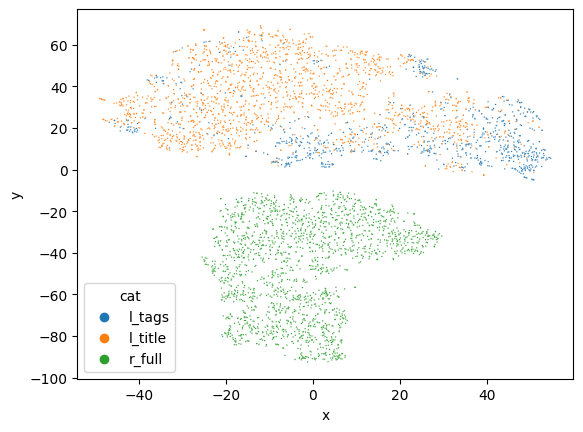

In [39]:
sns.scatterplot(
    data=ALL_EMBED_DF,
    x="x",
    y="y",
    s=1.0,
    hue="cat",
    hue_order=["l_tags", "l_title", "r_full"])

In [40]:
def scatter_embed(all_embeds, all_names, filter_name):
    tsne_embed = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric="cosine",
        n_jobs=-1).fit_transform(
            all_embeds[[
                ix
                for ix, name in enumerate(all_names)
                if name == filter_name
            ], :])
    embed_df = pd.DataFrame({
        "x": tsne_embed[:, 0],
        "y": tsne_embed[:, 1]})
    sns.scatterplot(
        data=embed_df,
        x="x",
        y="y",
        s=4.0).set(title=filter_name)

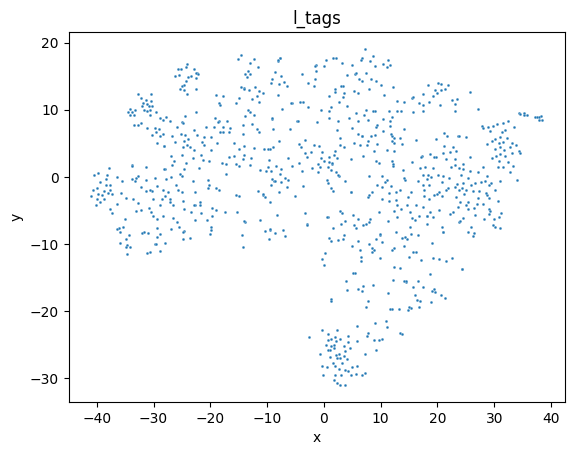

In [41]:
scatter_embed(ALL_EMBEDS, ALL_NAMES, "l_tags")

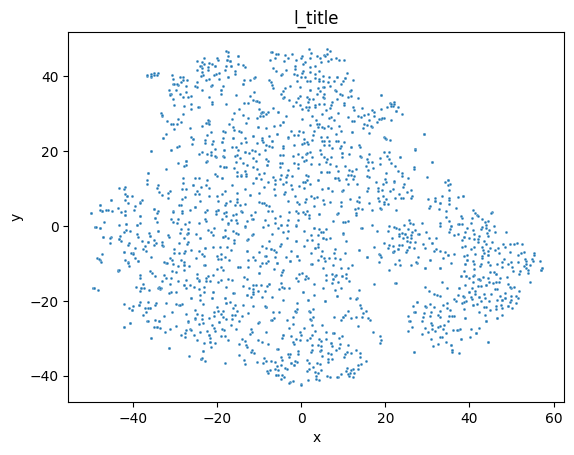

In [42]:
scatter_embed(ALL_EMBEDS, ALL_NAMES, "l_title")

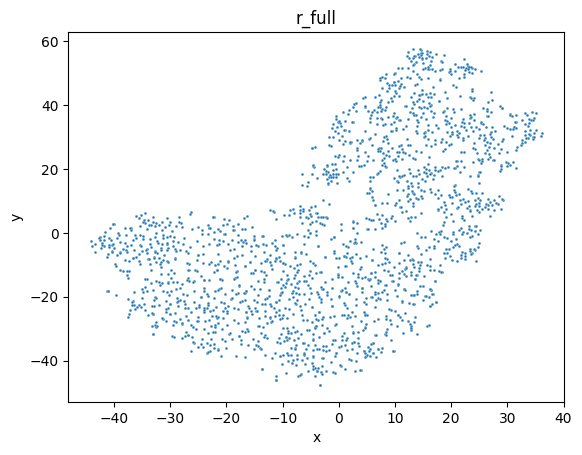

In [43]:
scatter_embed(ALL_EMBEDS, ALL_NAMES, "r_full")

In [44]:
#  Using the embeddings
# ======================

# 1. remove (clusters of) duplicate tags
# 2. suggest tags for a given title or title + text
# 3. allow to add new tags and suggest documents which might also fit that tag
# 4. prompt for searching related documents

In [45]:
def add_db(x: pd.DataFrame) -> pd.DataFrame:
    embeds = []
    add_embeds(pd.DataFrame({"text": x["text"].astype(str)}), harness, "", embeds, [], is_right=True)
    all_embeds = np.vstack(embeds)
    x = x[[col for col in x.columns if not col.startswith(TAG_PREFIX) and col != "stage"]]
    x["embedding"] = all_embeds.tolist()
    return x

LOOKUP_DF = DF.groupby("db", group_keys=False).apply(add_db)
LOOKUP_DF

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/2452 [00:00<?, ?it/s]

,id,db,country,lang,title,text,embedding
0,5019,sm,GIN,en,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,"[0.3536856174468994, -0.443826287984848, 0.561..."
1,5164,sm,GIN,en,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,"[0.27985548973083496, -0.4508509039878845, 0.5..."
2,5022,sm,GIN,en,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,"[0.2208986133337021, -0.4452027678489685, 0.58..."
3,2783,sm,GIN,en,Public Lights auto managed,Public Lights auto managed \nSolution developp...,"[0.3437137007713318, -0.45189717411994934, 0.5..."
4,5021,sm,GIN,en,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,"[0.21289579570293427, -0.5048496723175049, 0.6..."
...,...,...,...,...,...,...,...
4010,197,exp,LBY,en,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,"[0.2340654581785202, -0.48546725511550903, 0.5..."
4011,362,exp,GTM,en,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,"[0.234000101685524, -0.460847944021225, 0.5051..."
4012,252,exp,PHL,en,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...","[0.32142335176467896, -0.4646630585193634, 0.5..."
4013,241,exp,PHL,en,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,"[0.2595449686050415, -0.4679296612739563, 0.53..."


In [46]:
def from_embeds(df: pd.DataFrame) -> np.ndarray:
    return np.array(df["embedding"].to_list())

In [47]:
LOOKUP_EMBEDS = from_embeds(LOOKUP_DF)
LOOKUP_EMBEDS

array([[ 0.35368562, -0.44382629,  0.56191921, ...,  0.03879454,
        -0.36874595,  0.15919511],
       [ 0.27985549, -0.4508509 ,  0.57206571, ...,  0.02505868,
        -0.3688961 ,  0.12886856],
       [ 0.22089861, -0.44520277,  0.58529663, ..., -0.08329753,
        -0.33380809,  0.11088479],
       ...,
       [ 0.32142335, -0.46466306,  0.56062752, ...,  0.04519598,
        -0.3637968 ,  0.13783413],
       [ 0.25954497, -0.46792966,  0.53383982, ...,  0.03063669,
        -0.37049568,  0.09492151],
       [ 0.25291914, -0.4381882 ,  0.51052403, ...,  0.02742027,
        -0.37985122,  0.08098999]])

In [48]:
LOOKUP_EMBEDS.shape

(3467, 768)

In [49]:
def single_embed(
        prompt: str,
        harness: TrainingHarness) -> np.ndarray:
    model_left = harness.get_model_left()
    model_left.eval()
    with torch.no_grad():
        embed = model_left(tokens([prompt], False))
        return embed.numpy(force=True)

In [50]:
def get_distances(embeds: np.ndarray, single: np.ndarray) -> np.ndarray:
    x = embeds
    y = single.ravel().reshape((-1, 1))
    return 1.0 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [51]:
def search(
        df: pd.DataFrame,
        embeds: np.ndarray | None,
        prompt: str,
        harness: TrainingHarness) -> pd.DataFrame:
    if embeds is None:
        embeds = from_embeds(df)
    dists = get_distances(embeds, single_embed(prompt, harness)).ravel()
    res = df[["db", "title", "text"]].copy()
    res["dist"] = dists
    return res.sort_values("dist", ascending=True)

In [52]:
# "biogas from waste"
# "national innovation ecosystem and scalability"
# "social justice"
search_results = search(LOOKUP_DF, LOOKUP_EMBEDS, "biogas from waste", harness)
# search_results = search_results[search_results["db"] == "ap"]
search_results.head(5)

,db,title,text,dist
1143,sm,STREET HEALTH: Cardiologist to go.,STREET HEALTH: Cardiologist to go.\nMiguel los...,0.988035
2275,sm,M-SCAN Uganda- Innocent Menyo,M-SCAN Uganda- Innocent Menyo\nPortable ultras...,0.988208
1846,sm,"Re-use, Re-purposing of Liquor Bottles","Re-use, Re-purposing of Liquor Bottles\nLiquor...",0.988238
2016,sm,Center for Moms,Center for Moms\nA grassroots organization est...,0.988241
1576,sm,Transcribing voice into text and vice versa:,Transcribing voice into text and vice versa:\n...,0.988250


In [53]:
for s_ix in range(5):
    s_cur = search_results.iloc[s_ix]
    title = clean(s_cur["title"])
    bar_size = len(title) + 2
    print(f"┌{'─' * bar_size}┐")
    print(f"│ {title} │")
    print(f"└{'─' * bar_size}┘")
    print(clean(s_cur["text"]))
    print()

┌────────────────────────────────────┐
│ STREET HEALTH: Cardiologist to go. │
└────────────────────────────────────┘
STREET HEALTH: Cardiologist to go.
Miguel lost his job as a nurse. He took to the streets health and counseling on cardiology and more.
Public health, quick answers and advisory. 
The growing need for certainty and health has put accessible paths for advice on the streets.

┌───────────────────────────────┐
│ M-SCAN Uganda- Innocent Menyo │
└───────────────────────────────┘
M-SCAN Uganda- Innocent Menyo
Portable ultrasound scans that are compatible on laptops, tablets and mobile phones.

┌────────────────────────────────────────┐
│ Re-use, Re-purposing of Liquor Bottles │
└────────────────────────────────────────┘
Re-use, Re-purposing of Liquor Bottles
Liquor bottles re-purposed/re-used for soil conservation

┌─────────────────┐
│ Center for Moms │
└─────────────────┘
Center for Moms
A grassroots organization established to support mothers and advocate for their rights. 

In [54]:
# Data Sources
# 1. direct query feedback (like/dislike)
# 2. recording query and last clicked link

In [55]:
# concrete clusters

In [56]:
tag_matrix

,3d printing,Acupuntura Urbana,Bebidas Tradicionales,Bicicleta,Bicycle,Cadenas de Valor,Coca,Conectividad,Construction,Contactlessness,...,wood gas,wood stove,woodchips,worker safety,youth,youth activism,youth and unemployment,youth empowerment,youth informality,zero waste
3d printing,1.000000,0.988440,0.978707,0.985412,0.989276,0.985946,0.986117,0.993374,0.973918,0.994181,...,0.995195,0.992308,0.995621,0.987637,0.993260,0.989893,0.994724,0.995257,0.995081,0.995115
Acupuntura Urbana,0.988440,1.000000,0.995187,0.996386,0.978692,0.996798,0.975537,0.991346,0.966105,0.982660,...,0.992665,0.993412,0.993835,0.975157,0.982264,0.977668,0.986588,0.986327,0.987870,0.982740
Bebidas Tradicionales,0.978707,0.995187,1.000000,0.993802,0.967588,0.995941,0.963777,0.983126,0.955359,0.972477,...,0.986259,0.988336,0.987246,0.964569,0.971551,0.966103,0.978585,0.977319,0.979842,0.972247
Bicicleta,0.985412,0.996386,0.993802,1.000000,0.979525,0.996092,0.976706,0.989965,0.967461,0.981268,...,0.993364,0.994020,0.992952,0.974592,0.981689,0.977160,0.985490,0.985076,0.986530,0.982041
Bicycle,0.989276,0.978692,0.967588,0.979525,1.000000,0.977714,0.998790,0.993282,0.992615,0.995874,...,0.987506,0.982138,0.987679,0.993592,0.997198,0.997328,0.987908,0.990564,0.987256,0.996623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youth activism,0.989893,0.977668,0.966103,0.977160,0.997328,0.976736,0.996964,0.993673,0.986674,0.997764,...,0.987646,0.981461,0.988184,0.997161,0.998151,1.000000,0.990965,0.993700,0.990261,0.997627
youth and unemployment,0.994724,0.986588,0.978585,0.985490,0.987908,0.986046,0.984625,0.991557,0.971827,0.994742,...,0.995563,0.993170,0.993928,0.988948,0.994687,0.990965,1.000000,0.999212,0.999268,0.994486
youth empowerment,0.995257,0.986327,0.977319,0.985076,0.990564,0.985561,0.988112,0.992707,0.975379,0.996557,...,0.995464,0.992214,0.994095,0.991506,0.996652,0.993700,0.999212,1.000000,0.999014,0.996209
youth informality,0.995081,0.987870,0.979842,0.986530,0.987256,0.986721,0.984195,0.991763,0.970818,0.994459,...,0.996196,0.994117,0.995015,0.988333,0.993846,0.990261,0.999268,0.999014,1.000000,0.993894


In [79]:
def get_tag_clusters():
    cols = tag_matrix.columns
    cids = hc.fcluster(tag_linkage, 0.005, criterion="distance")
    res = collections.defaultdict(list)
    for col, cid in zip(cols, cids):
        res[int(cid)].append(f"{col}")
    return dict(res)
    
tag_clusters = get_tag_clusters()
len(tag_clusters)

75

<AxesSubplot: ylabel='Count'>

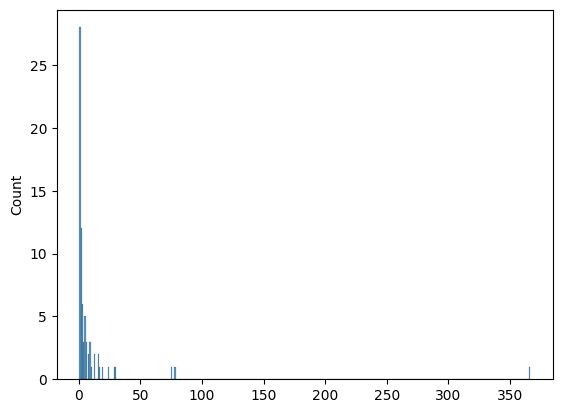

In [80]:
sns.histplot([len(c) for c in tag_clusters.values()], discrete=True)

In [81]:
with open(f"tag_clusters_{VERSION}.json", "w") as fout:
    print(json.dumps(tag_clusters, indent=2, sort_keys=True), file=fout)

In [82]:
LOOKUP_DF

,id,db,country,lang,title,text,embedding
0,5019,sm,GIN,en,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,"[0.3536856174468994, -0.443826287984848, 0.561..."
1,5164,sm,GIN,en,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,"[0.27985548973083496, -0.4508509039878845, 0.5..."
2,5022,sm,GIN,en,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,"[0.2208986133337021, -0.4452027678489685, 0.58..."
3,2783,sm,GIN,en,Public Lights auto managed,Public Lights auto managed \nSolution developp...,"[0.3437137007713318, -0.45189717411994934, 0.5..."
4,5021,sm,GIN,en,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,"[0.21289579570293427, -0.5048496723175049, 0.6..."
...,...,...,...,...,...,...,...
4010,197,exp,LBY,en,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,"[0.2340654581785202, -0.48546725511550903, 0.5..."
4011,362,exp,GTM,en,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,"[0.234000101685524, -0.460847944021225, 0.5051..."
4012,252,exp,PHL,en,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...","[0.32142335176467896, -0.4646630585193634, 0.5..."
4013,241,exp,PHL,en,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,"[0.2595449686050415, -0.4679296612739563, 0.53..."


In [83]:
def compute_doc_matrix(db: str) -> np.ndarray:
    df = LOOKUP_DF[LOOKUP_DF["db"] == db]
    res = np.zeros((df.shape[0], df.shape[0]))
    with tqdm(desc=db, total=df.shape[0] * df.shape[0]) as progress_bar:
        for rix in range(df.shape[0]):
            row = df.iloc[rix]
            for cix in range(df.shape[0]):
                progress_bar.update(1)
                if cix > rix:
                    continue
                col = df.iloc[cix]
                dist = get_distances(
                    np.array(row["embedding"]).ravel().reshape((1, -1)),
                    np.array(col["embedding"]))[0]
                res[rix, cix] = dist
                res[cix, rix] = dist
    return res, df["text"].astype(str)

def compute_doc_linkage(doc_matrix):
    return hc.linkage(sp.distance.squareform(doc_matrix.round(10)), method="average")

def get_doc_clusters(doc_linkage, prompts, *, th):
    cids = hc.fcluster(doc_linkage, th, criterion="distance")
    res = collections.defaultdict(list)
    for prompt, cid in zip(prompts, cids):
        res[int(cid)].append(f"{prompt}")
    return dict(res)

def get_doc_clusters_from_db(db: str, th: float) -> dict[int, str]:
    doc_matrix, doc_prompts = compute_doc_matrix(db)
    doc_linkage = compute_doc_linkage(doc_matrix)
    return get_doc_clusters(doc_linkage, doc_prompts, th=th)

In [84]:
sm_doc_matrix, sm_doc_prompts = compute_doc_matrix("sm")
sm_doc_matrix

sm:   0%|          | 0/6012304 [00:00<?, ?it/s]

array([[0.00000000e+00, 1.64843367e-03, 7.52165100e-03, ...,
        8.26224545e-04, 9.98318420e-04, 9.18435738e-03],
       [1.64843367e-03, 0.00000000e+00, 3.74308329e-03, ...,
        1.08098935e-03, 2.44476522e-03, 8.93444750e-03],
       [7.52165100e-03, 3.74308329e-03, 0.00000000e+00, ...,
        6.45780698e-03, 6.75555281e-03, 8.68607003e-03],
       ...,
       [8.26224545e-04, 1.08098935e-03, 6.45780698e-03, ...,
        0.00000000e+00, 1.98950346e-03, 1.00756324e-02],
       [9.98318420e-04, 2.44476522e-03, 6.75555281e-03, ...,
        1.98950346e-03, 1.11022302e-16, 1.00724033e-02],
       [9.18435738e-03, 8.93444750e-03, 8.68607003e-03, ...,
        1.00756324e-02, 1.00724033e-02, 1.11022302e-16]])

In [85]:
sm_doc_matrix.shape, sm_doc_matrix.round(10)

((2452, 2452),
 array([[0.        , 0.00164843, 0.00752165, ..., 0.00082622, 0.00099832,
         0.00918436],
        [0.00164843, 0.        , 0.00374308, ..., 0.00108099, 0.00244477,
         0.00893445],
        [0.00752165, 0.00374308, 0.        , ..., 0.00645781, 0.00675555,
         0.00868607],
        ...,
        [0.00082622, 0.00108099, 0.00645781, ..., 0.        , 0.0019895 ,
         0.01007563],
        [0.00099832, 0.00244477, 0.00675555, ..., 0.0019895 , 0.        ,
         0.0100724 ],
        [0.00918436, 0.00893445, 0.00868607, ..., 0.01007563, 0.0100724 ,
         0.        ]]))

In [86]:
sm_doc_linkage = compute_doc_linkage(sm_doc_matrix)

In [99]:
sm_doc_clusters = get_doc_clusters(sm_doc_linkage, sm_doc_prompts, th=0.0025)
len(sm_doc_clusters)

141

<AxesSubplot: ylabel='Count'>

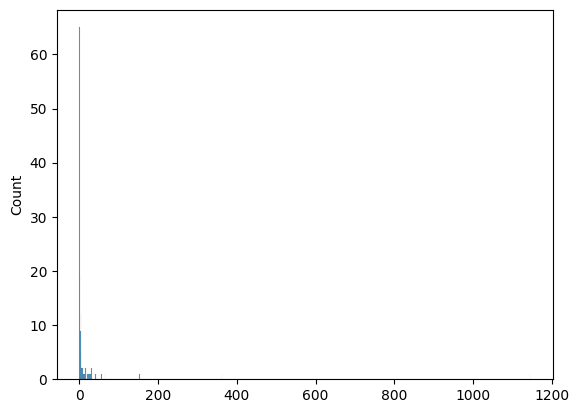

In [100]:
sns.histplot([len(c) for c in sm_doc_clusters.values()], discrete=True)

In [101]:
with open(f"sm_doc_clusters_{VERSION}.json", "w") as fout:
    print(json.dumps(sm_doc_clusters, indent=2, sort_keys=True), file=fout)

ap:   0%|          | 0/677329 [00:00<?, ?it/s]

<AxesSubplot: ylabel='Count'>

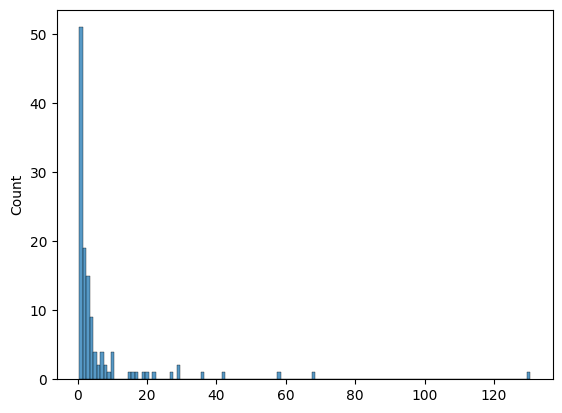

In [104]:
ap_doc_clusters = get_doc_clusters_from_db("ap", 0.0003)
sns.histplot([len(c) for c in ap_doc_clusters.values()], discrete=True)

In [105]:
len(ap_doc_clusters)

125

In [106]:
with open(f"ap_doc_clusters_{VERSION}.json", "w") as fout:
    print(json.dumps(ap_doc_clusters, indent=2, sort_keys=True), file=fout)

<AxesSubplot: ylabel='Count'>

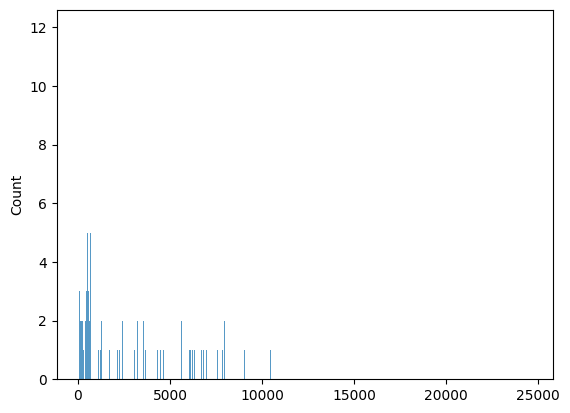

In [107]:
sns.histplot([len(clean(txt)) for txt in LOOKUP_DF["text"]], discrete=True)

In [108]:
ix = np.argmax([len(clean(txt)) for txt in LOOKUP_DF["text"]])
ix, DF.iloc[ix], len(LOOKUP_DF.iloc[ix]["text"])

(2912,
 stage                         validation
 id                                   274
 db                                    ap
 country                              PAN
 lang                                  en
                                  ...    
 tag_youth activism                 False
 tag_youth and unemployment         False
 tag_youth empowerment              False
 tag_youth informality              False
 tag_zero waste                     False
 Name: 3445, Length: 881, dtype: object,
 24578)

In [109]:
VERSION

7